## Predictive Modeling - Problem Definition
Our goal is to build a binary classification model to predict whether a delivery will be late, based solely on information available at the time of purchase.

Target variable: `is_late`  
Type: Binary Classification (0 = On time, 1 = Late)


In [71]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.parquet import to_parquet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [72]:
# Import dataframe
current_dir = os.getcwd()
data_path = os.path.abspath(os.path.join(current_dir, "..", "data", "processed"))
df_modeling = pd.read_parquet(os.path.join(data_path, "df_model.parquet"))



In [73]:
# Checking dataframe
df_modeling.columns.unique()

Index(['product_volume', 'product_weight_g', 'freight_value', 'payment_value',
       'price', 'estimated_time', 'order_purchase_month', 'customer_state',
       'seller_state', 'distance_category', 'is_late'],
      dtype='object')

In [74]:
df_modeling.head(5)

,product_volume,product_weight_g,freight_value,payment_value,price,estimated_time,order_purchase_month,customer_state,seller_state,distance_category,is_late
0,1976.0,500.0,8.72,18.12,29.99,15,10,SP,SP,short,0
1,1976.0,500.0,8.72,2.00,29.99,15,10,SP,SP,short,0
2,1976.0,500.0,8.72,18.59,29.99,15,10,SP,SP,short,0
3,4693.0,400.0,22.76,141.46,118.70,17,7,BA,SP,short,0
4,9576.0,420.0,19.22,179.12,159.90,26,8,GO,SP,short,0


### Feature Engineering Pt. 2

#### Region Mapping
To help the model generalize better, we grouped Brazilian states into regions (North, Northeast, Central-West, Southeast, and South). This reduces the number of unique categories and captures broader geographic trends that may influence delivery delays.

In [75]:
# Mapping Brazilian states to regions
state_to_region = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

In [76]:
# Mapping customer_state to region
df_modeling['customer_region'] = df_modeling['customer_state'].map(state_to_region)
df_modeling.drop(columns="customer_state")

,product_volume,product_weight_g,freight_value,payment_value,price,estimated_time,order_purchase_month,seller_state,distance_category,is_late,customer_region
0,1976.0,500.0,8.72,18.12,29.99,15,10,SP,short,0,Sudeste
1,1976.0,500.0,8.72,2.00,29.99,15,10,SP,short,0,Sudeste
2,1976.0,500.0,8.72,18.59,29.99,15,10,SP,short,0,Sudeste
3,4693.0,400.0,22.76,141.46,118.70,17,7,SP,short,0,Nordeste
4,9576.0,420.0,19.22,179.12,159.90,26,8,SP,short,0,Centro-Oeste
...,...,...,...,...,...,...,...,...,...,...,...
115931,16000.0,4950.0,20.10,195.00,174.90,23,2,SP,short,0,Sudeste
115932,63360.0,13300.0,65.02,271.01,205.99,30,8,SP,short,0,Nordeste
115933,8000.0,6550.0,40.59,441.16,179.99,37,1,MG,short,0,Sudeste
115934,8000.0,6550.0,40.59,441.16,179.99,37,1,MG,short,0,Sudeste


In [77]:
# Mapping seller_state to region
df_modeling['seller_region'] = df_modeling['seller_state'].map(state_to_region)
df_modeling.drop(columns="seller_state")

,product_volume,product_weight_g,freight_value,payment_value,price,estimated_time,order_purchase_month,customer_state,distance_category,is_late,customer_region,seller_region
0,1976.0,500.0,8.72,18.12,29.99,15,10,SP,short,0,Sudeste,Sudeste
1,1976.0,500.0,8.72,2.00,29.99,15,10,SP,short,0,Sudeste,Sudeste
2,1976.0,500.0,8.72,18.59,29.99,15,10,SP,short,0,Sudeste,Sudeste
3,4693.0,400.0,22.76,141.46,118.70,17,7,BA,short,0,Nordeste,Sudeste
4,9576.0,420.0,19.22,179.12,159.90,26,8,GO,short,0,Centro-Oeste,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...
115931,16000.0,4950.0,20.10,195.00,174.90,23,2,SP,short,0,Sudeste,Sudeste
115932,63360.0,13300.0,65.02,271.01,205.99,30,8,BA,short,0,Nordeste,Sudeste
115933,8000.0,6550.0,40.59,441.16,179.99,37,1,RJ,short,0,Sudeste,Sudeste
115934,8000.0,6550.0,40.59,441.16,179.99,37,1,RJ,short,0,Sudeste,Sudeste


In [78]:
# Pré processing 
# get dummies for categorical features
df_modeling_encoded = pd.get_dummies(df_modeling, drop_first=True)


In [79]:
# Split the dataset into training and testing sets
X = df_modeling_encoded.drop('is_late', axis=1)
y = df_modeling_encoded['is_late']


In [80]:
# Function to run the models

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, ConfusionMatrixDisplay

def train_evaluate_model(model, X, y, scale_data=False):
    """
    Train and evaluate classification model with cross-validation and test metrics.

    Parameters:
    - model: sklearn-like estimator (already initialized)
    - X: features (DataFrame or array)
    - y: target (Series or array)
    - scale_data: bool, if True applies StandardScaler to features

    Outputs:
    - Prints CV mean scores and test scores
    - Plots confusion matrix for test set
    """

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale if requested
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    cv_results = cross_validate(
        model,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    mean_cv_scores = {metric: cv_results[f'test_{metric}'].mean() for metric in scoring}
    print("\nCross-Validation Mean Scores:")
    print(pd.Series(mean_cv_scores).round(4))

    # Train model on full train set
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate test scores
    test_scores = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    if y_proba is not None:
        test_scores['roc_auc'] = roc_auc_score(y_test, y_proba)

    print("\nTest Set Scores:")
    print(pd.Series(test_scores).round(4))

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix - Test Set")
    plt.show()   


Cross-Validation Mean Scores:
accuracy     0.7959
precision    0.2089
recall       0.5824
f1           0.3074
roc_auc      0.7756
dtype: float64

Test Set Scores:
accuracy     0.7882
precision    0.2045
recall       0.5959
f1           0.3045
roc_auc      0.7770
dtype: float64


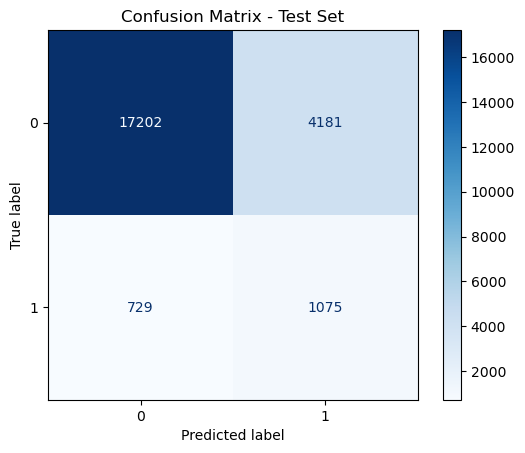

In [81]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42, max_depth = 10, class_weight='balanced')
train_evaluate_model(rf, X, y, scale_data=False)



Cross-Validation Mean Scores:
accuracy     0.6420
precision    0.1320
recall       0.6463
f1           0.2192
roc_auc      0.7002
dtype: float64

Test Set Scores:
accuracy     0.6378
precision    0.1299
recall       0.6414
f1           0.2160
roc_auc      0.6969
dtype: float64


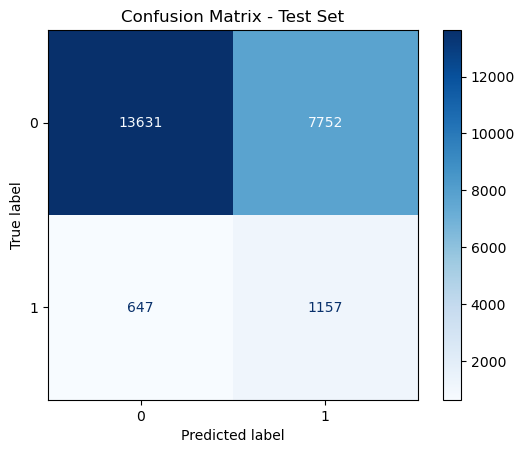

In [82]:
# Logistic Regression (with scaling)
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
train_evaluate_model(logreg, X, y, scale_data=True)

c:\Users\ricka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ricka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ricka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ricka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Paramet


Cross-Validation Mean Scores:
accuracy     0.9270
precision    0.5888
recall       0.2054
f1           0.3045
roc_auc      0.8087
dtype: float64


c:\Users\ricka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Test Set Scores:
accuracy     0.9297
precision    0.6337
recall       0.2273
f1           0.3346
roc_auc      0.8230
dtype: float64


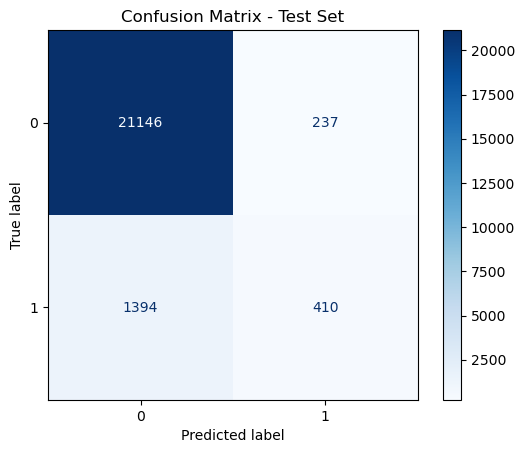

In [83]:
# XGBoost (without scaling)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth = 10, min_samples_leaf = 2000, random_state=42)
train_evaluate_model(xgb, X, y, scale_data=False)

### Model Selection Justification

Three classification models were evaluated: Random Forest, Logistic Regression, and XGBoost. The selection was based primarily on the F1-score, as it provides a balanced metric between recall (identifying late deliveries) and precision (avoiding unnecessary alerts for on-time deliveries).

Given the business context, it was essential to choose a model that not only detects delayed orders effectively but also minimizes false positives that could lead to operational inefficiencies or unnecessary customer concern.

The model with the highest F1-score was selected as the final candidate. The next step involves performing hyperparameter tuning to further optimize its performance, followed by a more detailed evaluation of the final metrics on the test data.

In [84]:
from collections import Counter
# Calculate the class imbalance ratio (negative / positive)
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 11.85


In [85]:
# Base XGBoost model without fixed scale_pos_weight
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Grid of hyperparameters for optimization
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight]  # trying with and without class balancing
}


In [86]:
# Use F1-score as the evaluation metric
f1 = make_scorer(f1_score, pos_label=1)

# Stratified K-Fold cross-validation to preserve class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch with parallel processing (n_jobs=-1)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=f1,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train model with GridSearch
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\ricka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 11.854885654885654],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
             verbose=1)

In [87]:
# Best hyperparameters and corresponding F1-score (CV average)
print("Best parameters:", grid_search.best_params_)
print("Best F1 score (cross-validation):", grid_search.best_score_)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 11.854885654885654, 'subsample': 0.8}
Best F1 score (cross-validation): 0.35137273516408457


In [88]:
# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Full classification report on the test set
print("Test Classification Report:\n")
print(classification_report(y_test, y_pred))


Test Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     21383
           1       0.24      0.67      0.35      1804

    accuracy                           0.81     23187
   macro avg       0.60      0.75      0.62     23187
weighted avg       0.91      0.81      0.85     23187



### Metrics Evaluation

In order to better understand the trade-offs between precision and recall, and to make a more informed decision on the optimal classification threshold, we will now evaluate the model performance across different probability thresholds.

By analyzing the Precision-Recall curve, ROC-AUC curve, and the F1-score as a function of the threshold, we aim to find a balanced decision point that minimizes the cost of false positives (predicting late when it's not) and false negatives (missing actual late deliveries).

This step is essential especially in business contexts where the cost of wrongly predicting a late delivery can impact customer satisfaction or operational planning.

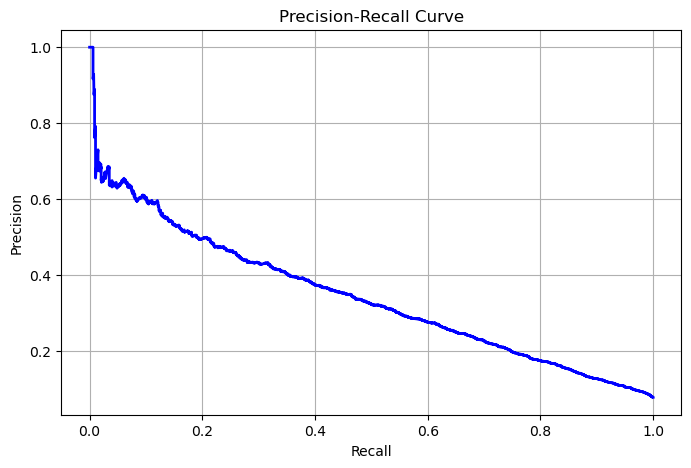

In [90]:
# Precision-Recall Curve

from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score,
    f1_score)

# Get predicted probabilities for the positive class
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)

# Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


The shape of the curve suggests that the model struggles to maintain both high precision and high recall simultaneously. Therefore, selecting an appropriate threshold is crucial to balance the cost of missing late deliveries (false negatives) and incorrectly flagging on-time deliveries as late (false positives).

This analysis highlights the importance of choosing a threshold that maximizes the F1-score, ensuring a balanced performance between recall and precision.

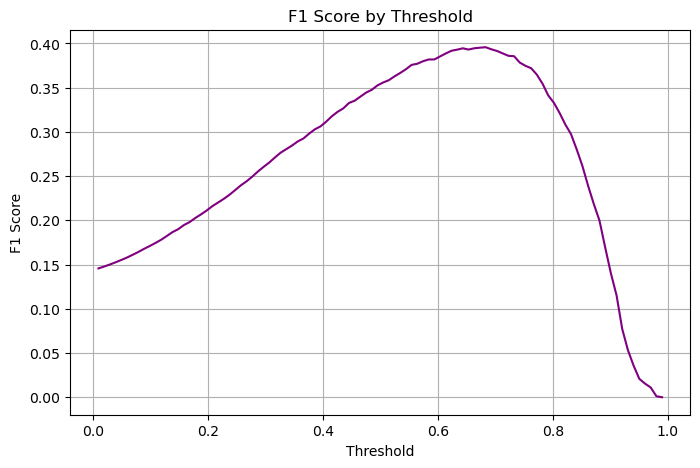

In [91]:
# Calculate F1-score for different thresholds
f1_scores = []
thresholds_f1 = np.linspace(0.01, 0.99, 100)

for t in thresholds_f1:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds_f1, f1_scores, color='purple')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score by Threshold")
plt.grid(True)
plt.show()


The F1 score curve with respect to the threshold suggests that the optimal threshold for achieving the best balance between precision and recall is approximately 6.8

In [112]:
# tuning the threshold

threshold = 0.68  # por exemplo, mais sensível a atrasos
y_pred_custom = (y_proba >= threshold).astype(int)


In [113]:
from sklearn.metrics import classification_report, confusion_matrix

print(f"Classification report (threshold = {threshold}):")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion matrix:")
print(pd.DataFrame(cm,
                   index=['Actual 0', 'Actual 1'],
                   columns=['Predicted 0', 'Predicted 1']))


Classification report (threshold = 0.68):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     21383
           1       0.35      0.46      0.40      1804

    accuracy                           0.89     23187
   macro avg       0.65      0.70      0.67     23187
weighted avg       0.91      0.89      0.90     23187

Confusion matrix:
          Predicted 0  Predicted 1
Actual 0        19818         1565
Actual 1          966          838


Threshold Adjustment and Model Performance

After adjusting the classification threshold, the model achieved an F1-score of **0.40**, with a **precision of 0.35** and a **recall of 0.45**. These metrics suggest that the model is able to correctly identify **45% of the deliveries that will be delayed** (recall). However, among all the deliveries the model predicts as delayed, **only 35% are actually delayed** (precision). This trade-off indicates that the model is moderately effective at capturing delays but still generates a significant number of false positives. Further tuning or feature engineering may be necessary to improve this balance.


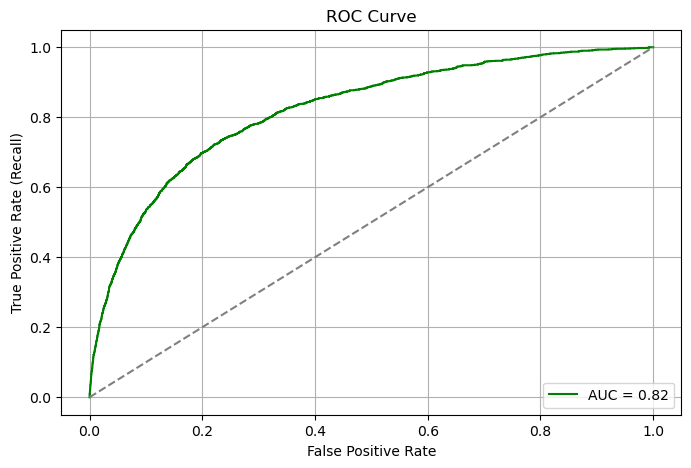

In [ ]:
# Checking the ROC-AUC curve

# Compute FPR and TPR for ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='green', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


ROC Curve and AUC Analysis

The ROC curve (Receiver Operating Characteristic) plots the **true positive rate** (recall) against the **false positive rate** for various classification thresholds. It shows how well the model distinguishes between the two classes—delayed and on-time deliveries—across all possible thresholds.

Our model achieved an **AUC (Area Under the Curve) of 0.82**, which indicates **good overall discriminative ability**. In other words, there is an 82% chance that the model will assign a higher probability of delay to a randomly selected late delivery than to a randomly selected on-time delivery.

However, despite this strong AUC score, our **precision and recall at a specific threshold are relatively low**. This means that:

- The model is good at **ranking** deliveries by their likelihood of being late (as the AUC shows),
- But it is not yet good at **making accurate binary decisions** (delay vs. no delay) at the chosen threshold.



### Project Conclusion

Our model achieved an **AUC (Area Under the Curve) of 0.82**, which indicates **good overall discriminative ability**.
However, despite this strong AUC score, our **precision and recall are relatively low**. This means that:

- The model is good at **ranking** deliveries by their likelihood of being late (as the AUC shows),
- But it is not yet good at **making accurate binary decisions** (delay vs. no delay).

This situation typically suggests that the model is producing **reasonable probability scores**, but the model still has **room for improvement in precision/recall**.

#### Practical takeaway:
To improve the model's practical use it's important to:
- Consider using the predicted probability (risk score) directly for decision-making instead of a binary output.
- Create new features that explains the model better.

This insight highlights the importance of **looking beyond a single threshold** and using evaluation tools to fully understand model behavior.

